In [1]:
library(data.table)
library(ggplot2)
library(dplyr)
library(lme4)
library(repr)

# Change plot size to 4 x 3
options(repr.plot.width = 4, repr.plot.height = 3, repr.plot.pointsize = 11)

DATA_DIR <- "../data/"


Attaching package: ‘dplyr’

The following objects are masked from ‘package:data.table’:

    between, first, last

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: Matrix


In [2]:
get_radon_data <- function() {
    DATA_PATH <- paste0(DATA_DIR, "radon/srrs2.dat")
    data <- read.table(DATA_PATH, header = T, sep = ",")
    # write.csv(data, "radon.csv")
    return(data)
}


prepare_data_for_state  <- function(state) {
    radon_data <- get_radon_data()
    # Get data for state
    state_data <- radon_data[radon_data["state"] == state,]
    
    # Calculate the log radon levels
    state_data$log_radon <-
        log(ifelse(state_data$activity == 0 | is.na(state_data$activity), 
                   0.1, 
                   state_data$activity))
    
    # Code counties as indices
    state_data$county_idx <- as.integer(factor(state_data$county))
    
    # county means of the radon level
    state_data <- state_data %>%
        dplyr::group_by(county_idx) %>%
        dplyr::mutate(county_mean = mean(log_radon, na.rm = TRUE))
    
    # the number of obs per county
    state_data <- state_data %>%
        dplyr::group_by(county_idx) %>%
        dplyr::mutate(nobs_county = n())
    
    # total mean of the radon level
    state_data$total_mean <- mean(state_data$log_radon)
    
    # County level variance and overall variance
    state_data <- state_data %>%
        dplyr::group_by(county_idx) %>%
        dplyr::mutate(county_var = var(log_radon, na.rm = TRUE))
    
    # To calculate the variance between counties, we first collect the county
    # level eans yet again in a separate data.table
    df <- state_data %>%
        dplyr::group_by(county_idx) %>%
        dplyr::summarise(cnty_mean = mean(log_radon, na.rm = TRUE))
    
    state_data$total_var <- var(df$cnty_mean, na.rm = TRUE)
    
    return(state_data)
}

multlevel_radon <- function(state_data) {
    state_data$multlevel_mean <- 
    ((state_data$nobs_county / state_data$county_var) * state_data$county_mean + 
    (1 / state_data$total_var) * state_data$total_mean) / 
    ((state_data$nobs_county / state_data$county_var) + (1 / state_data$total_var))
    
    return(state_data)
}

sample_mean_vs_sample_sz <- function(data_table, nobs_cutoff) {
    df <- data_table[data_table$nobs_county < nobs_cutoff, ]
    # plot(df$nobs_county, df$county_mean)
    ggplot() + 
    geom_point(data = df, aes(x = df$nobs_county, y = df$county_mean), color = "blue") 
}

radon_vs_floor <- function(data_table, county_idx) {
    df <- data_table[data_table["county_idx"] == county_idx, ]
    # plot(df$floor, df$log_radon)
    ggplot() + 
    geom_point(data = df, aes(x = df$floor, y = df$log_radon), color = "blue") 
}
 
main <- function() {
    state_data <- prepare_data_for_state("MN")
    state_data <- multlevel_radon(state_data)
    
    
    n <- length(state_data)
    y <- state_data$log_radon
    x <- state_data$floor
    
    return(state_data)
    #plot(state_data$county_idx, y)
    #lm(formula = y ~ x)
}

In [3]:
df <- main()

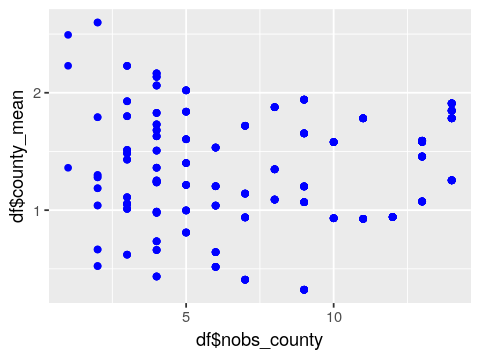

In [4]:
sample_mean_vs_sample_sz(df, nobs_cutoff = 20)

In [5]:
print(df[, c("county_idx", "nobs_county", "county_mean", "total_mean", "total_var", 
             "county_var", "multlevel_mean")])

# A tibble: 919 x 7
# Groups:   county_idx [85]
   county_idx nobs_county county_mean total_mean total_var county_var
        <int>       <int>       <dbl>      <dbl>     <dbl>      <dbl>
 1          1           4       0.660       1.22     0.237      0.211
 2          1           4       0.660       1.22     0.237      0.211
 3          1           4       0.660       1.22     0.237      0.211
 4          1           4       0.660       1.22     0.237      0.211
 5          2          52       0.833       1.22     0.237      0.593
 6          2          52       0.833       1.22     0.237      0.593
 7          2          52       0.833       1.22     0.237      0.593
 8          2          52       0.833       1.22     0.237      0.593
 9          2          52       0.833       1.22     0.237      0.593
10          2          52       0.833       1.22     0.237      0.593
# … with 909 more rows, and 1 more variable: multlevel_mean <dbl>


In [6]:
df <- as.data.table(df)
setkey(df, county)
df[county_idx == 1, ]

idnum,state,state2,stfips,zip,region,typebldg,floor,room,basement,⋯,cntyfips,county,log_radon,county_idx,county_mean,nobs_county,total_mean,county_var,total_var,multlevel_mean
5081,MN,MN,27,55735,5,1,1,3,N,⋯,1,AITKIN,0.7884574,1,0.6604064,4,1.224623,0.2107976,0.2373249,0.7629283
5082,MN,MN,27,55748,5,1,0,4,Y,⋯,1,AITKIN,0.7884574,1,0.6604064,4,1.224623,0.2107976,0.2373249,0.7629283
5083,MN,MN,27,55748,5,1,0,4,Y,⋯,1,AITKIN,1.0647107,1,0.6604064,4,1.224623,0.2107976,0.2373249,0.7629283
5084,MN,MN,27,56469,5,1,0,4,Y,⋯,1,AITKIN,0.0000000,1,0.6604064,4,1.224623,0.2107976,0.2373249,0.7629283


In [7]:
df[,.N, by=county]

county,N
AITKIN,4
ANOKA,52
BECKER,3
BELTRAMI,7
BENTON,4
BIG STONE,3
BLUE EARTH,14
BROWN,4
CARLTON,10
CARVER,6


In [8]:
colnames(df)

[1] "idnum"          "state"          "state2"         "stfips"        
 [5] "zip"            "region"         "typebldg"       "floor"         
 [9] "room"           "basement"       "windoor"        "rep"           
[13] "stratum"        "wave"           "starttm"        "stoptm"        
[17] "startdt"        "stopdt"         "activity"       "pcterr"        
[21] "adjwt"          "dupflag"        "zipflag"        "cntyfips"      
[25] "county"         "log_radon"      "county_idx"     "county_mean"   
[29] "nobs_county"    "total_mean"     "county_var"     "total_var"     
[33] "multlevel_mean"

In [9]:
df <- as.data.frame(df)
# df$county <- as.numeric(df$county)
df[which(df$county_idx == 1), ]
# radon_vs_floor(df, "LAC QUI PARLE")

idnum,state,state2,stfips,zip,region,typebldg,floor,room,basement,⋯,cntyfips,county,log_radon,county_idx,county_mean,nobs_county,total_mean,county_var,total_var,multlevel_mean
5081,MN,MN,27,55735,5,1,1,3,N,⋯,1,AITKIN,0.7884574,1,0.6604064,4,1.224623,0.2107976,0.2373249,0.7629283
5082,MN,MN,27,55748,5,1,0,4,Y,⋯,1,AITKIN,0.7884574,1,0.6604064,4,1.224623,0.2107976,0.2373249,0.7629283
5083,MN,MN,27,55748,5,1,0,4,Y,⋯,1,AITKIN,1.0647107,1,0.6604064,4,1.224623,0.2107976,0.2373249,0.7629283
5084,MN,MN,27,56469,5,1,0,4,Y,⋯,1,AITKIN,0.0000000,1,0.6604064,4,1.224623,0.2107976,0.2373249,0.7629283


In [10]:
df[which(as.numeric(df$county) == 4), ]

idnum,state,state2,stfips,zip,region,typebldg,floor,room,basement,⋯,cntyfips,county,log_radon,county_idx,county_mean,nobs_county,total_mean,county_var,total_var,multlevel_mean
5081,MN,MN,27,55735,5,1,1,3,N,⋯,1,AITKIN,0.7884574,1,0.6604064,4,1.224623,0.2107976,0.2373249,0.7629283
5082,MN,MN,27,55748,5,1,0,4,Y,⋯,1,AITKIN,0.7884574,1,0.6604064,4,1.224623,0.2107976,0.2373249,0.7629283
5083,MN,MN,27,55748,5,1,0,4,Y,⋯,1,AITKIN,1.0647107,1,0.6604064,4,1.224623,0.2107976,0.2373249,0.7629283
5084,MN,MN,27,56469,5,1,0,4,Y,⋯,1,AITKIN,0.0000000,1,0.6604064,4,1.224623,0.2107976,0.2373249,0.7629283


In [11]:
for (row in 1:nrow(df)) {
    county <- df[row, "county"]
    county_idx  <- df[row, "county_idx"]

    print(paste(county, ": ", county_idx))
}

[1] "AITKIN               :  1"
[1] "AITKIN               :  1"
[1] "AITKIN               :  1"
[1] "AITKIN               :  1"
[1] "ANOKA                :  2"
[1] "ANOKA                :  2"
[1] "ANOKA                :  2"
[1] "ANOKA                :  2"
[1] "ANOKA                :  2"
[1] "ANOKA                :  2"
[1] "ANOKA                :  2"
[1] "ANOKA                :  2"
[1] "ANOKA                :  2"
[1] "ANOKA                :  2"
[1] "ANOKA                :  2"
[1] "ANOKA                :  2"
[1] "ANOKA                :  2"
[1] "ANOKA                :  2"
[1] "ANOKA                :  2"
[1] "ANOKA                :  2"
[1] "ANOKA                :  2"
[1] "ANOKA                :  2"
[1] "ANOKA                :  2"
[1] "ANOKA                :  2"
[1] "ANOKA                :  2"
[1] "ANOKA                :  2"
[1] "ANOKA                :  2"
[1] "ANOKA                :  2"
[1] "ANOKA                :  2"
[1] "ANOKA                :  2"
[1] "ANOKA                :  2"
[1] "ANO

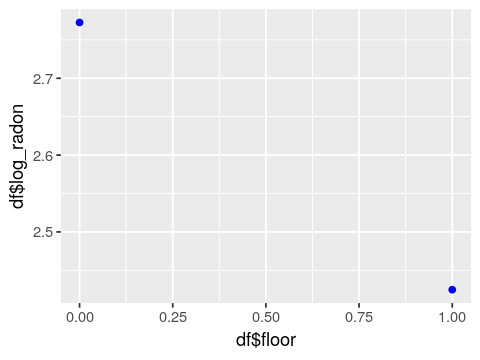

In [12]:
radon_vs_floor(df, 36)

## 12.3 Partial pooling with predictors

In [13]:
n <- length(df)
y <- df$log_radon
x <- df$floor
county <- df$county

### Complete pooling

In the complete pooling model, we do not distinguish between counties (ignore all county-level predictors). 

In [14]:
M0 <- lm(y ~ x)

In [15]:
M0


Call:
lm(formula = y ~ x)

Coefficients:
(Intercept)            x  
     1.3267      -0.6134  


### No pooling regression

In [16]:
colnames(df)

[1] "idnum"          "state"          "state2"         "stfips"        
 [5] "zip"            "region"         "typebldg"       "floor"         
 [9] "room"           "basement"       "windoor"        "rep"           
[13] "stratum"        "wave"           "starttm"        "stoptm"        
[17] "startdt"        "stopdt"         "activity"       "pcterr"        
[21] "adjwt"          "dupflag"        "zipflag"        "cntyfips"      
[25] "county"         "log_radon"      "county_idx"     "county_mean"   
[29] "nobs_county"    "total_mean"     "county_var"     "total_var"     
[33] "multlevel_mean"

In [17]:
n <- length(df)
y <- df$log_radon
x <- df$floor
county <- df$county
county_idx <- df$county_idx

M1 <- lm(y ~ x + factor(county) - 1)

In [18]:
summary(M1)


Call:
lm(formula = y ~ x + factor(county) - 1)

Residuals:
     Min       1Q   Median       3Q      Max 
-3.14595 -0.45405  0.00065  0.45376  2.65987 

Coefficients:
                                   Estimate Std. Error t value Pr(>|t|)    
x                                  -0.72054    0.07352  -9.800  < 2e-16 ***
factor(county)AITKIN                0.84054    0.37866   2.220 0.026701 *  
factor(county)ANOKA                 0.87482    0.10498   8.333 3.23e-16 ***
factor(county)BECKER                1.52870    0.43946   3.479 0.000530 ***
factor(county)BELTRAMI              1.55272    0.28897   5.373 1.00e-07 ***
factor(county)BENTON                1.43257    0.37866   3.783 0.000166 ***
factor(county)BIG STONE             1.51301    0.43672   3.464 0.000558 ***
factor(county)BLUE EARTH            2.01216    0.20243   9.940  < 2e-16 ***
factor(county)BROWN                 1.98958    0.37999   5.236 2.08e-07 ***
factor(county)CARLTON               1.00304    0.23931   4.191 3.07e-05 *

### Plots: Pooling vs No-Pooling

In [19]:
radon_vs_floor2 <- function(c0_p, c1_p, c0_np, c1_np, text) {
    # p = pooled coefficients
    # np = no-pooled coefficients
    
    # This is for plotting the complete pooled linear regression 
    i <- 1
    x <- seq(0.0, 1.0, 0.01)
    y1 <- list()
    
    for (idx in x) {
        y1[[i]] <- c0_p - c1_p * idx
        i <- i + 1
    }
    
    df_pooled <- data.frame(x, y1)
    
    # This is for the no-pooled linear regression
    y2 <- list()
    i <- 1
    
    for (idx in x) {
        y2[[i]] <- c0_np + idx * (c1_np - c0_np)
        i <- i + 1
    }
    
    df_no_pool <- data.frame(x, y2)
    
    cols = c("floor", "log_radon")
    colnames(df_pooled) = cols
    colnames(df_no_pool) = cols
    
    ggplot() + ggtitle(text) + ylim(-3.0, +3.0) + 
    geom_line(data = df_pooled, aes(x = floor, y = log_radon, colour = "Pooled"), linetype = "dotted") +
    geom_line(data = df_no_pool, aes(x = floor, y = log_radon, colour = "No Pooling")) +
    scale_colour_manual("", breaks = c("Pooled", "No Pooling"), values = c("blue", "red")) 
}

In [20]:
c0_p <- 1.3267      
c1_p <- -0.6134

c1_np <- -0.72054

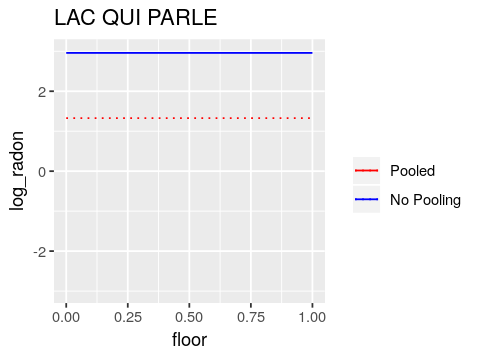

In [21]:
df_lqp = df[df['county_idx'] == 36, ]
y_lqp <- df_lqp$log_radon
x_lqp <- df_lqp$floor

c0_np <- 2.95897

radon_vs_floor2(c0_p, c1_p, c0_np, c1_np, "LAC QUI PARLE")

In [22]:
# What if we fitted a model separately for each county 
M_lqp <- lm(y_lqp ~ x_lqp)
summary(M_lqp)


Call:
lm(formula = y_lqp ~ x_lqp)

Residuals:
ALL 2 residuals are 0: no residual degrees of freedom!

Coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept)   2.7726         NA      NA       NA
x_lqp        -0.3478         NA      NA       NA

Residual standard error: NaN on 0 degrees of freedom
Multiple R-squared:      1,	Adjusted R-squared:    NaN 
F-statistic:   NaN on 1 and 0 DF,  p-value: NA


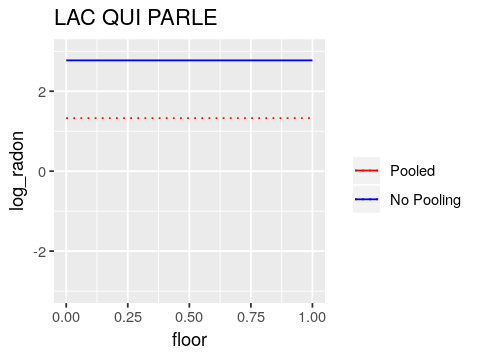

In [23]:
radon_vs_floor2(c0_p, c1_p, c0_np = 2.7726, c1_np = -0.3478, "LAC QUI PARLE")

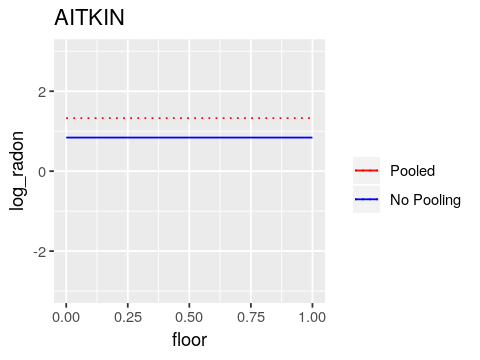

In [24]:
df_aitkin = df[df['county_idx'] == 1, ]
y_ait <- df_aitkin$log_radon
x_ait <- df_aitkin$floor

c0_np <- 0.84054

radon_vs_floor2(c0_p, c1_p, c0_np, c1_np, "AITKIN")

In [25]:
M_ait <- lm(y_ait ~ x_ait)
summary(M_ait)


Call:
lm(formula = y_ait ~ x_ait)

Residuals:
         1          2          3          4 
-5.551e-17  1.707e-01  4.470e-01 -6.177e-01 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept)   0.6177     0.3190   1.936    0.192
x_ait         0.1707     0.6380   0.268    0.814

Residual standard error: 0.5525 on 2 degrees of freedom
Multiple R-squared:  0.03457,	Adjusted R-squared:  -0.4481 
F-statistic: 0.07162 on 1 and 2 DF,  p-value: 0.8141


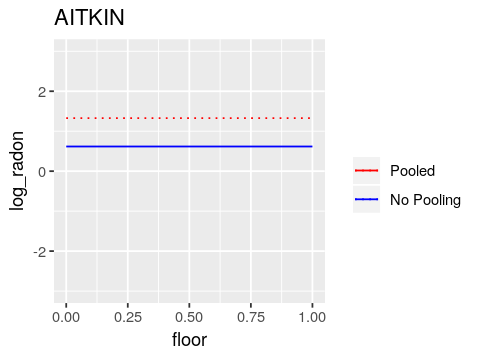

In [26]:
radon_vs_floor2(c0_p, c1_p, c0_np = 0.6177, c1_np = 0.1707, "AITKIN")

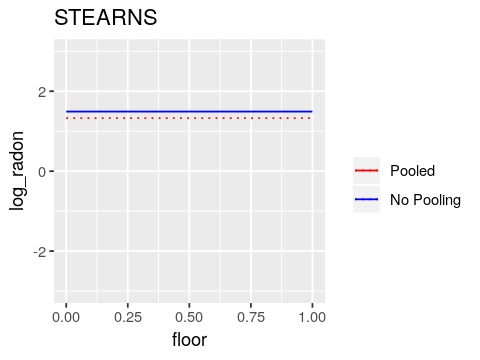

In [27]:
df_stearns = df[df['county_idx'] == 71, ]
y <- df_stearns$log_radon
x <- df_stearns$floor

c0_np <- 1.49184

radon_vs_floor2(c0_p, c1_p, c0_np, c1_np, "STEARNS")

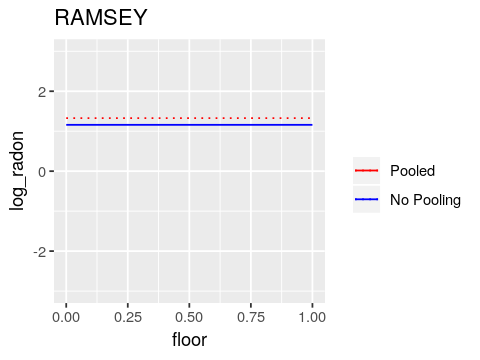

In [28]:
df_ram = df[df['county_idx'] == 61, ]
y <- df_ram$log_radon
x <- df_ram$floor

c0_np <- 1.15873

radon_vs_floor2(c0_p, c1_p, c0_np, c1_np, "RAMSEY")

In [29]:
df_result = data.frame("coeff" = M1$coefficients, "se" = sqrt(diag(vcov(M1))))

In [30]:
head(df_result)

,coeff,se
x,-0.7205390,0.0735232
factor(county)AITKIN,0.8405411,0.3786561
factor(county)ANOKA,0.8748191,0.1049822
factor(county)BECKER,1.5286973,0.4394610
factor(county)BELTRAMI,1.5527222,0.2889702
factor(county)BENTON,1.4325705,0.3786561


In [31]:
df_result <- df_result[-c(1), ]
head(df_result)

,coeff,se
factor(county)AITKIN,0.8405411,0.3786561
factor(county)ANOKA,0.8748191,0.1049822
factor(county)BECKER,1.5286973,0.4394610
factor(county)BELTRAMI,1.5527222,0.2889702
factor(county)BENTON,1.4325705,0.3786561
factor(county)BIG STONE,1.5130101,0.4367190


In [32]:
df_result['nobs_county'] <- (df %>%
        dplyr::group_by(county_idx) %>%
        dplyr::summarize(nobs_county = n()))[, 2]
# df_result <- df_result[df$nobs_county, ]

In [33]:
head(df_result)

,coeff,se,nobs_county
factor(county)AITKIN,0.8405411,0.3786561,4
factor(county)ANOKA,0.8748191,0.1049822,52
factor(county)BECKER,1.5286973,0.4394610,3
factor(county)BELTRAMI,1.5527222,0.2889702,7
factor(county)BENTON,1.4325705,0.3786561,4
factor(county)BIG STONE,1.5130101,0.4367190,3


### Multilevel Model

In [ ]:
y <- df$log_radon
x <- df$floor
